In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
selected_ev            = 2        # which Eigenvector to choose
ϵ                      = 0.2      # perturbation
t₀                      = 0.6     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();
δ                      = 0

0

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end]

T (generic function with 1 method)

In [5]:
T_inv(x,p) = flow(rot_double_gyre, x, [t₀ + p, 0.0],     
    tolerance = solver_tolerance, solver = solver)[end]

T_inv (generic function with 1 method)

In [6]:
LL, UR = (0.0+δ, 0.0+δ), (1.0-δ, 1.0-δ)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [7]:
error(x) = norm(abs.(x - T_inv(T(x,0),0)))
errors = []
for node in ctx.grid.nodes
   push!(errors,error(node.x))
end

In [8]:
print(sum(errors),"\n")
print(maximum(errors),"\n")
print(mean(errors),"\n")

3.000099794822189
0.05376248276872431
0.0003000099794822189


In [9]:
M = assembleMassMatrix(ctx);

In [10]:
@time A,_ = nonAdaptiveTOCollocation(ctx, y -> T_inv(y,0),project_in=true);

  1.226380 seconds (3.50 M allocations: 241.794 MiB, 4.55% gc time)


In [11]:
@time D⁰ = assembleStiffnessMatrix(ctx)
@time D¹ = A'*D⁰*A
K = 0.5(D⁰+D¹);

  0.399162 seconds (1.41 M allocations: 82.554 MiB, 6.48% gc time)
  0.112671 seconds (235.99 k allocations: 24.480 MiB)


In [12]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
u₀ = u₀*sign(sum(u₀))            # fix sign
λ₀

  4.227384 seconds (8.89 M allocations: 612.424 MiB, 3.05% gc time)


-50.07087808794919

In [13]:
# assemble the linear response matrix L
@time L = nonadaptiveTOCollocationLinearResponseMatrix(ctx, T, A, 0);

  6.102201 seconds (19.63 M allocations: 1.194 GiB, 10.14% gc time)


In [14]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀ ; 0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  1.068795 seconds (2.46 M allocations: 223.694 MiB, 3.72% gc time)


-100.33919838021711

In [15]:
# calculate the exact uϵ
@time Aϵ,_ = nonAdaptiveTOCollocation(ctx, y -> T_inv(y,ϵ),project_in=true);
@time D¹ϵ = Aϵ'*D⁰*Aϵ
Kϵ = 0.5(D⁰+D¹ϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
uϵ = uϵ*sign(sum(uϵ))
λϵ

  0.342658 seconds (988.90 k allocations: 114.283 MiB, 5.30% gc time)
  0.009263 seconds (28 allocations: 12.577 MiB)


-62.34272476897897

In [16]:
λ₀ + ϵ*λ_dot

-70.13871776399262

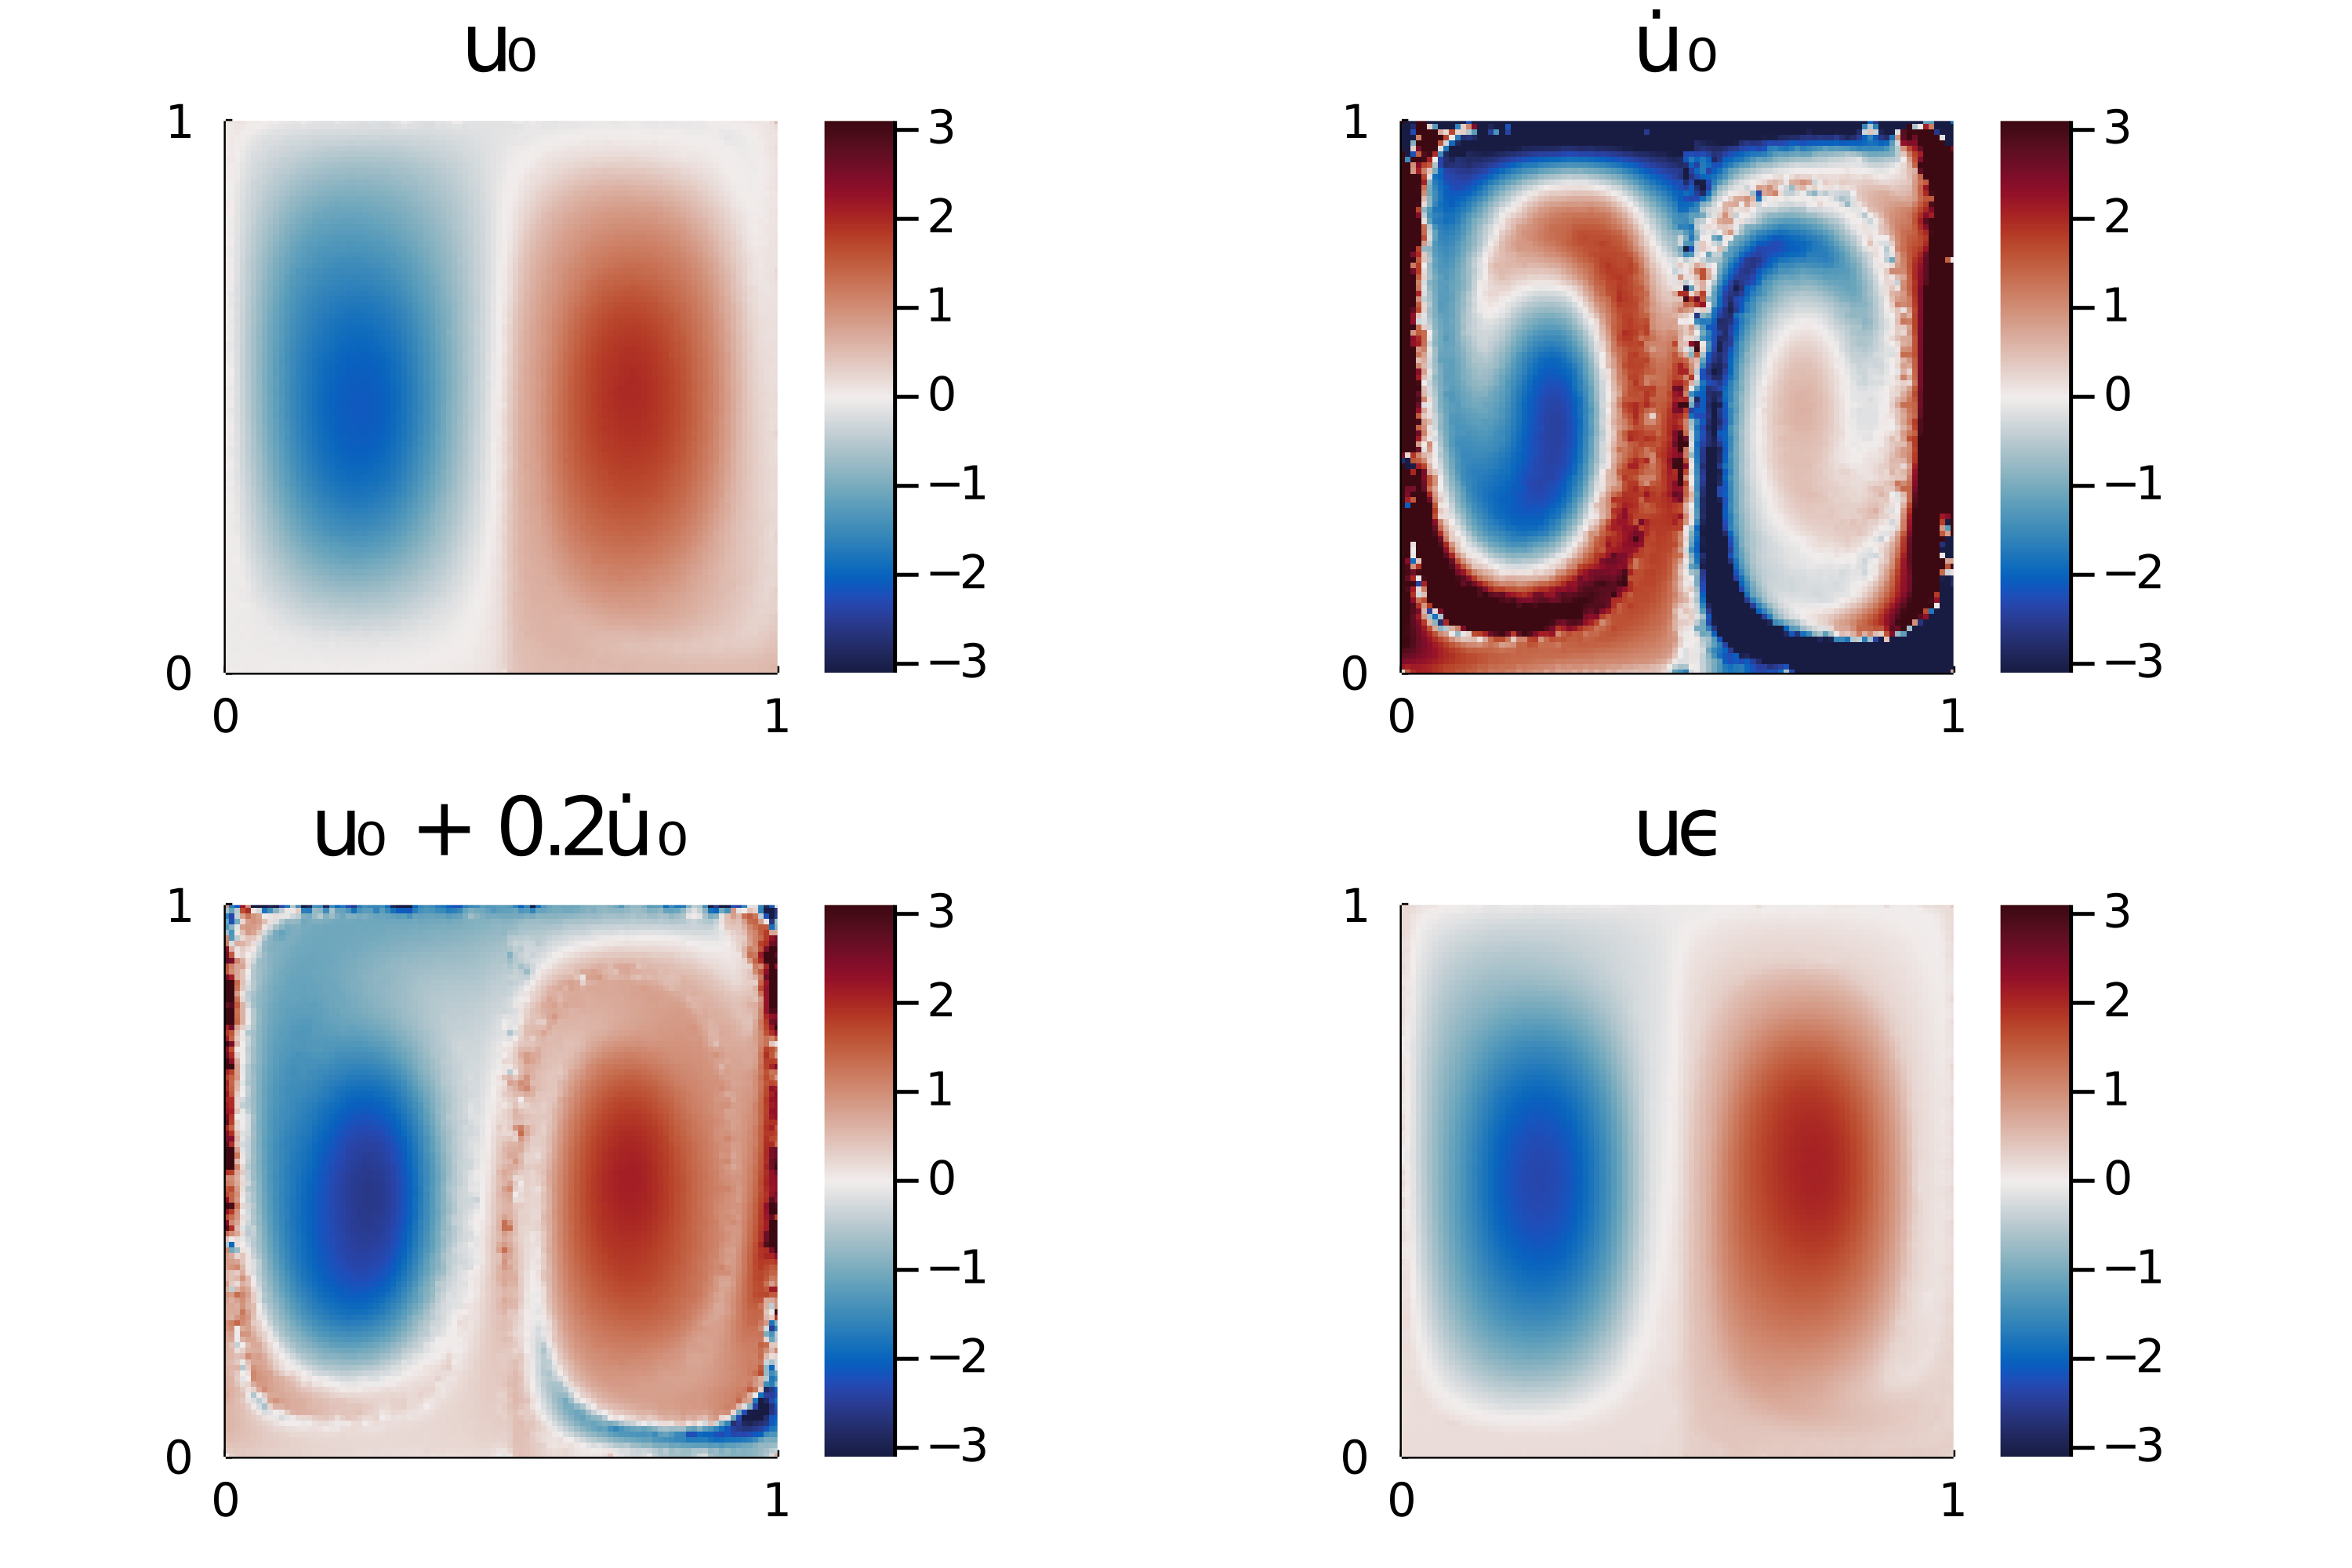

In [17]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -3.1
cmax =     3.1
cmin_lr =  -3.1
cmax_lr =  3.1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [18]:
using Contour

In [19]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0013285744740598737
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.005452925925831131
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.009577277377602389
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.01370162882937409
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.01782598028114535
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.021950331732916606
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.026074683184688308
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.030199034636459565
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.03432338608823127
└ @ Main In[19]:15
┌ Warning: Currently 

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.33952539351931676
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.34364974497108847
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.3477740964228597
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.351898447874631
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.3560227993264027
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.36014715077817394
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.36427150222994564
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.3683958536817169
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.37252020513348816
└ @ Main In[19]:15
┌ Warning: Currently only connect

Dynamic Cheeger value:	9.221749513152103
Levelset:		0.3354010420675455


┌ Warning: Currently only connected levelsets are allowed! Levelset: 1.9892659742278886
└ @ Main In[19]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 1.9933903256796603
└ @ Main In[19]:15


cheeger value		length			length transported	volume
10.57248498438894	1.7964955931789428	2.6426606270247146	0.20993911208000776
15.421413376791643	5.528533461023674	6.282222238295544	0.6170663670460407


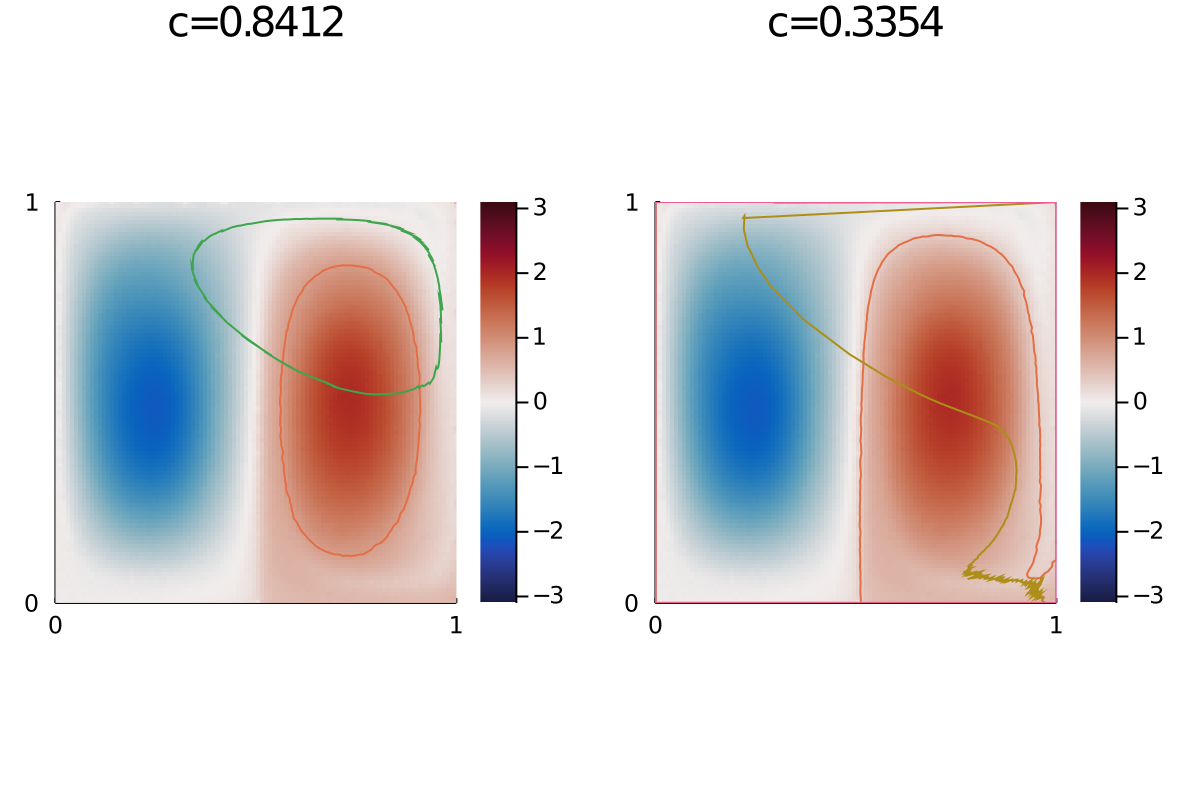

In [20]:
# value from paper
c_paper = 0.8412
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_paper))
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], x->T(x,0))
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_ours))
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], x->T(x,0))
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot(plot_paper,plot_ours,fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

In [25]:
using PyCall
using PyPlot
@pyimport matplotlib.pyplot as plt

ErrorException: [91m@pyimport: plt already defined[39m

In [26]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 2 methods)

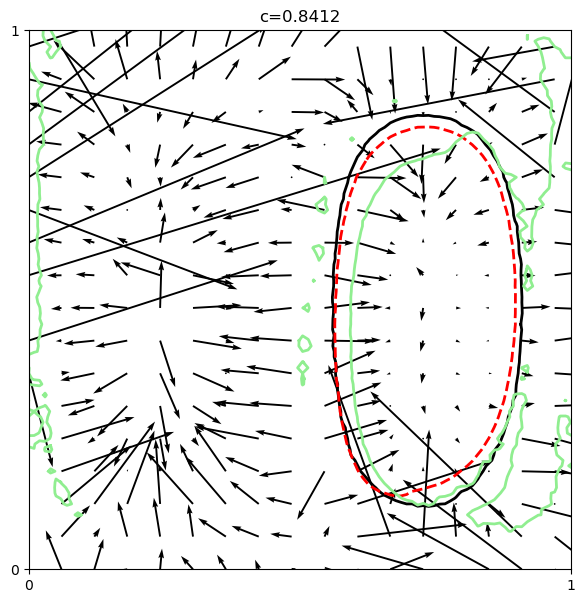

In [29]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,ax,scale=25,step=6)
curves           = lines(get_levelset(ctx, u₀, c_paper))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_paper))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_paper,digits=4))");

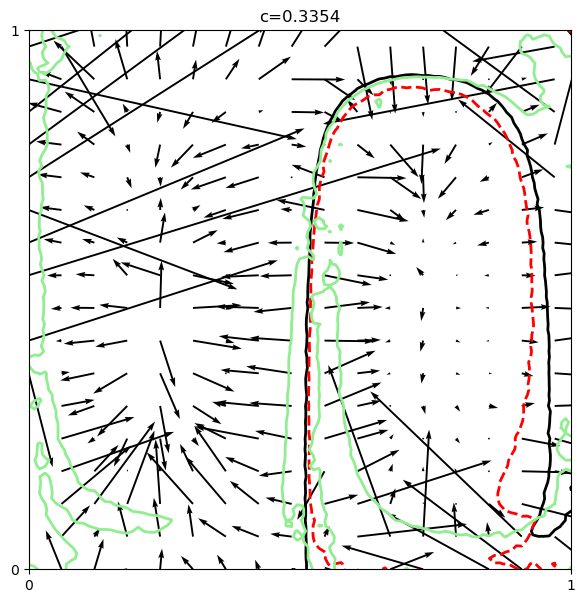

In [30]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,ax,scale=25,step=6)
curves           = lines(get_levelset(ctx, u₀, c_ours))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_ours))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_ours))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_ours,digits=4))");